# Visualize Simulation Data
This notebook loads in the simulated and original gene expression data used in `simulate_expresssion.py`, and looks at how similar they are

In [1]:
import copy
import json
import pickle
import os
import random 

import numpy as np
import pandas as pd
import umap
import tensorflow as tf
import yaml
from plotnine import *
from sklearn import preprocessing, decomposition

from saged import datasets, utils

In [2]:
# Set seeds
random.seed(42)
np.random.seed(42)
tf.set_random_seed(42)

In [3]:
base_dir = '../..'
# This is hacky, but the config files in this project give relative paths from the base directory
os.chdir(base_dir)

In [4]:
dataset_config_file = 'dataset_configs/refinebio_labeled_dataset.yml'

In [5]:
label = 'sepsis'
negative_class = 'healthy'
batch_correction_method = 'limma'

with open(dataset_config_file) as data_file:
    dataset_config = yaml.safe_load(data_file)

run_metadata_file = 'data/simulated/sepsis_healthy_simulation_metadata.json'
with open(run_metadata_file) as metadata_file:
    sim_metadata = json.load(metadata_file)
    
scaler_file = 'data/simulated/sepsis_healthy_labeled_scaler.pkl'
with open(scaler_file, 'rb') as in_file:
    scaler = pickle.load(in_file)

all_data, labeled_data, unlabeled_data = datasets.load_binary_data(dataset_config_file,
                                                                   'sepsis',
                                                                   'healthy')

In [6]:
disease_samples = copy.deepcopy(labeled_data).subset_samples_to_labels([label])

# Find which studies have data for the disease of interest
sample_to_study = all_data.get_samples_to_studies()
disease_studies = disease_samples.get_studies()
all_samples = all_data.get_samples()
all_labeled_samples = labeled_data.get_samples()

# Get all samples in those studies
disease_experiment_samples = utils.get_samples_in_studies(all_labeled_samples,
                                                          disease_studies, sample_to_study)

# Create a LabeledDataset object with those samples
disease_data = labeled_data.subset_to_samples(disease_experiment_samples)

In [7]:
# Correct for batch effects
disease_data = datasets.correct_batch_effects(disease_data, batch_correction_method)

In [8]:
print(len(sim_metadata['test_samples']))

242


In [9]:
# # Get the samples used in training
train_samples = sim_metadata['train_samples']

disease_data = disease_data.subset_to_samples(train_samples)

disease_only_data = copy.deepcopy(disease_data).subset_samples_to_labels([label])
healthy_only_data = copy.deepcopy(disease_data).subset_samples_to_labels([negative_class])

In [10]:
# # Scale the data with the same scaler used to train the VAEs
disease_array, _ = disease_only_data.get_all_data()
healthy_array, _ = healthy_only_data.get_all_data()
disease_array = scaler.transform(disease_array)
healthy_array = scaler.transform(healthy_array)

In [11]:
sim_disease = np.loadtxt('data/simulated/sepsis_sim.tsv', delimiter='\t')
sim_healthy = np.loadtxt('data/simulated/sepsis_healthy_sim.tsv', delimiter='\t')

In [12]:
print(disease_array.mean())
print(healthy_array.mean())
print(sim_disease.mean())
print(sim_healthy.mean())
healthy_array_copy = copy.deepcopy(healthy_array)

0.2698556196653646
0.2715116562897686
0.26496901545195883
0.3094132106017611


In [13]:
print(disease_array.shape)
print(healthy_array.shape)
print(sim_disease.shape)
print(sim_healthy.shape)

(1098, 14634)
(314, 14634)
(10000, 14634)
(10000, 14634)


In [14]:
all_disease = np.concatenate([disease_array, sim_disease], axis=0)
all_healthy = np.concatenate([healthy_array, sim_healthy], axis=0)
print(all_disease.shape)
print(all_healthy.shape)

(11098, 14634)
(10314, 14634)


In [15]:
reducer = umap.UMAP(random_state=42)
all_disease_umap = reducer.fit_transform(all_disease)
all_disease_umap.shape

(11098, 2)

In [16]:
reducer = umap.UMAP(random_state=42)
all_healthy_umap = reducer.fit_transform(all_healthy)

In [17]:
all_disease_df = pd.DataFrame(all_disease_umap, columns=['UMAP 1', 'UMAP 2'])
all_healthy_df = pd.DataFrame(all_healthy_umap, columns=['UMAP 1', 'UMAP 2'])

In [18]:
disease_labels = ['real'] * disease_array.shape[0] + ['simulated'] * sim_disease.shape[0]
healthy_labels = ['real'] * healthy_array.shape[0] + ['simulated'] * sim_healthy.shape[0]

In [19]:
all_disease_df['Simulation or Real'] = disease_labels
all_healthy_df['Simulation or Real'] = healthy_labels

In [20]:
all_disease_df

,UMAP 1,UMAP 2,Simulation or Real
0,2.355458,3.630894,real
1,4.025633,1.429797,real
2,3.182546,5.995615,real
3,3.460127,5.156669,real
4,2.079773,1.537687,real
...,...,...,...
11093,5.764095,4.906476,simulated
11094,3.449316,2.058559,simulated
11095,2.924531,3.355792,simulated
11096,1.354457,4.589742,simulated


In [21]:
all_healthy_df

,UMAP 1,UMAP 2,Simulation or Real
0,2.147559,2.277003,real
1,1.992090,4.615799,real
2,2.581831,5.025347,real
3,1.875707,3.623094,real
4,1.599750,5.003119,real
...,...,...,...
10309,3.688632,1.777627,simulated
10310,5.180761,5.589857,simulated
10311,3.589520,5.915442,simulated
10312,6.404593,6.448168,simulated


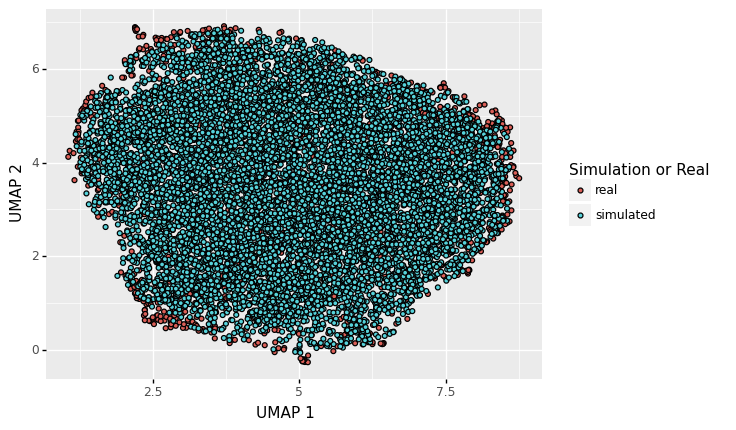

<ggplot: (8787725900445)>

In [22]:
ggplot(all_disease_df, aes(x='UMAP 1', y='UMAP 2', fill='Simulation or Real')) + geom_point(alpha=1)

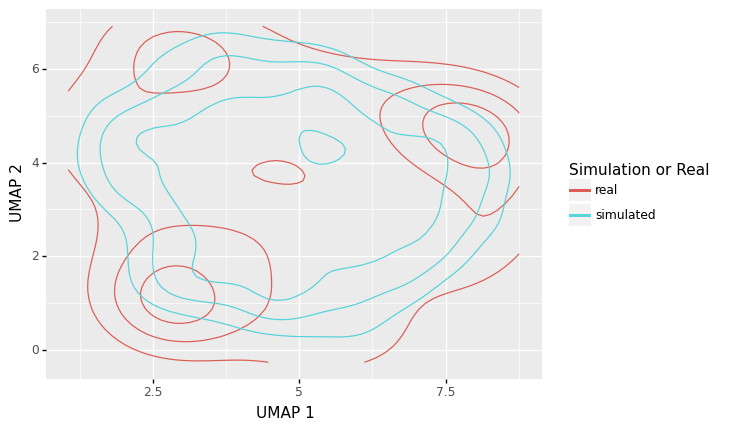

<ggplot: (8787725452869)>

In [23]:
ggplot(all_disease_df, aes(x='UMAP 1', y='UMAP 2', color='Simulation or Real')) + geom_density_2d()

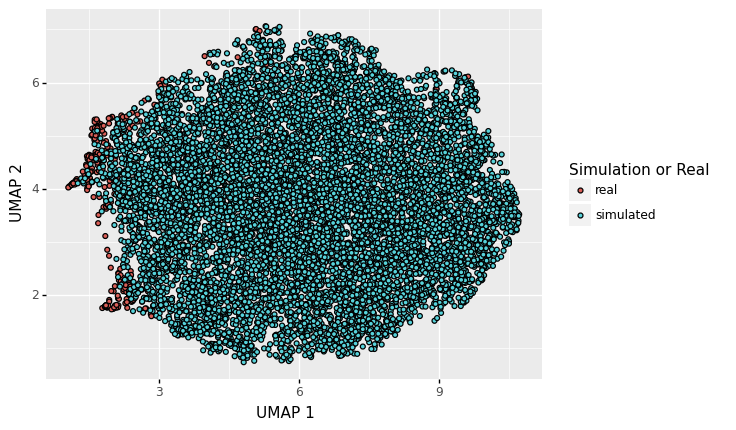

<ggplot: (8787785770789)>

In [24]:
ggplot(all_healthy_df, aes(x='UMAP 1', y='UMAP 2', fill='Simulation or Real')) + geom_point()

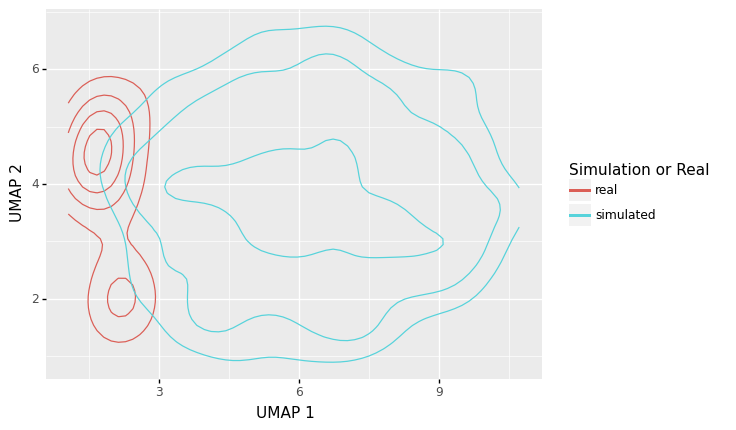

<ggplot: (8787786414457)>

In [25]:
ggplot(all_healthy_df, aes(x='UMAP 1', y='UMAP 2', color='Simulation or Real')) + geom_density_2d()

In [26]:
reducer = decomposition.PCA(n_components=2)
all_disease_umap = reducer.fit_transform(all_disease)
all_disease_umap.shape

(11098, 2)

In [27]:
reducer = decomposition.PCA(n_components=2)
all_healthy_umap = reducer.fit_transform(all_healthy)

In [28]:
all_disease_df = pd.DataFrame(all_disease_umap, columns=['PC1', 'PC2'])
all_healthy_df = pd.DataFrame(all_healthy_umap, columns=['PC1', 'PC2'])

In [29]:
all_disease_df['Simulation or Real'] = disease_labels
all_healthy_df['Simulation or Real'] = healthy_labels

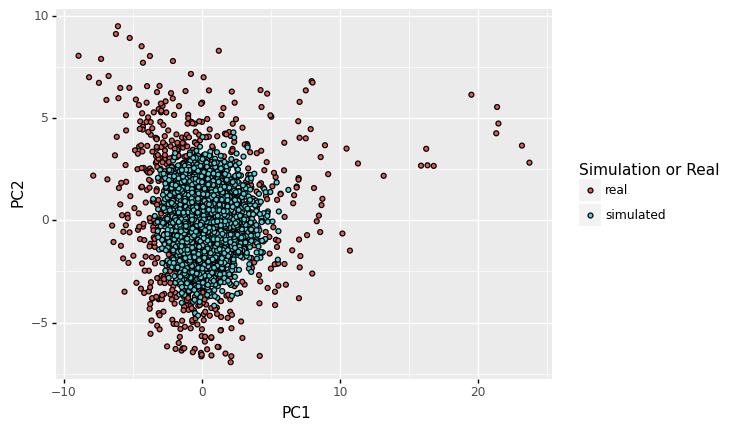

<ggplot: (8787786845341)>

In [30]:
ggplot(all_disease_df, aes(x='PC1', y='PC2', fill='Simulation or Real')) + geom_point()

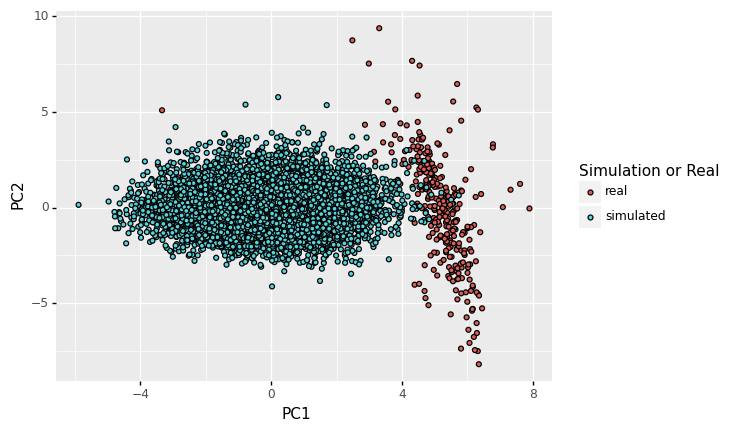

<ggplot: (8787793956933)>

In [31]:
ggplot(all_healthy_df, aes(x='PC1', y='PC2', fill='Simulation or Real')) + geom_point()

## Load exact data used in training

In [32]:
with open('data/simulated/sepsis_train.pkl', 'rb') as in_file:  
    disease_array = pickle.load(in_file)
with open('data/simulated/sepsis_healthy_train.pkl', 'rb') as in_file:
    healthy_array = pickle.load(in_file) 

In [33]:
print(disease_array.mean())
print(healthy_array.mean())
print(sim_disease.mean())
print(sim_healthy.mean())

0.26985561966536453
0.2715116562897687
0.26496901545195883
0.3094132106017611


In [34]:
print(disease_array.shape)
print(healthy_array.shape)
print(sim_disease.shape)
print(sim_healthy.shape)

(1098, 14634)
(314, 14634)
(10000, 14634)
(10000, 14634)


In [35]:
all_disease = np.concatenate([disease_array, sim_disease], axis=0)
all_healthy = np.concatenate([healthy_array, sim_healthy], axis=0)
print(all_disease.shape)
print(all_healthy.shape)

(11098, 14634)
(10314, 14634)


In [36]:
reducer = umap.UMAP(random_state=42)
all_disease_umap = reducer.fit_transform(all_disease)
all_disease_umap.shape

(11098, 2)

In [37]:
reducer = umap.UMAP(random_state=42)
all_healthy_umap = reducer.fit_transform(all_healthy)

In [38]:
all_disease_df = pd.DataFrame(all_disease_umap, columns=['UMAP 1', 'UMAP 2'])
all_healthy_df = pd.DataFrame(all_healthy_umap, columns=['UMAP 1', 'UMAP 2'])

In [39]:
disease_labels = ['real'] * disease_array.shape[0] + ['simulated'] * sim_disease.shape[0]
healthy_labels = ['real'] * healthy_array.shape[0] + ['simulated'] * sim_healthy.shape[0]

In [40]:
all_disease_df['Simulation or Real'] = disease_labels
all_healthy_df['Simulation or Real'] = healthy_labels

In [41]:
all_disease_df

,UMAP 1,UMAP 2,Simulation or Real
0,8.173028,3.546582,real
1,8.358275,2.851662,real
2,4.865546,-0.173470,real
3,5.874808,6.094920,real
4,6.279635,5.761838,real
...,...,...,...
11093,5.512325,5.242497,simulated
11094,3.325606,2.028036,simulated
11095,2.698032,3.300772,simulated
11096,1.101931,4.352417,simulated


In [42]:
all_healthy_df

,UMAP 1,UMAP 2,Simulation or Real
0,2.428042,1.774812,real
1,1.767207,2.903710,real
2,1.381424,4.003390,real
3,1.687540,3.136328,real
4,1.911834,2.566590,real
...,...,...,...
10309,3.852474,1.556072,simulated
10310,4.742166,5.541174,simulated
10311,3.232176,5.784424,simulated
10312,6.174307,6.612375,simulated


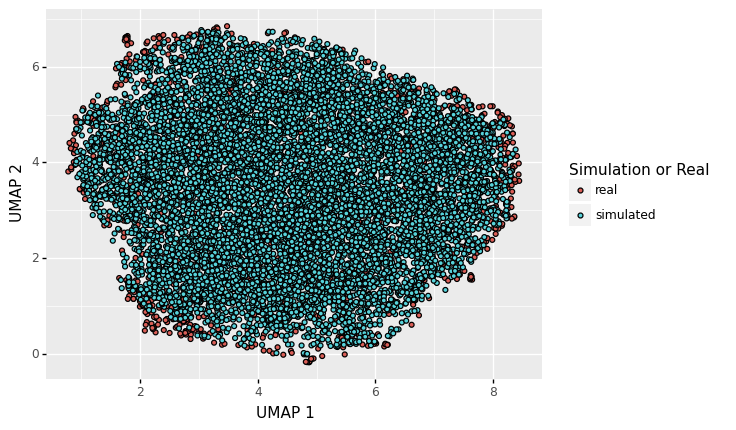

<ggplot: (8787794755097)>

In [43]:
ggplot(all_disease_df, aes(x='UMAP 1', y='UMAP 2', fill='Simulation or Real')) + geom_point(alpha=1)

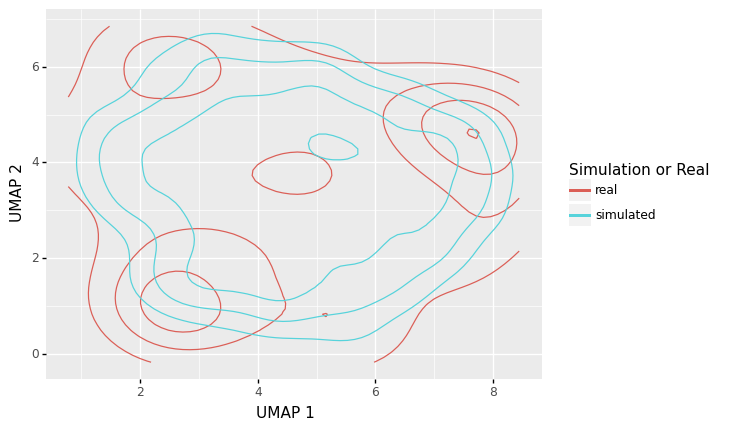

<ggplot: (8787794607373)>

In [44]:
ggplot(all_disease_df, aes(x='UMAP 1', y='UMAP 2', color='Simulation or Real')) + geom_density_2d()

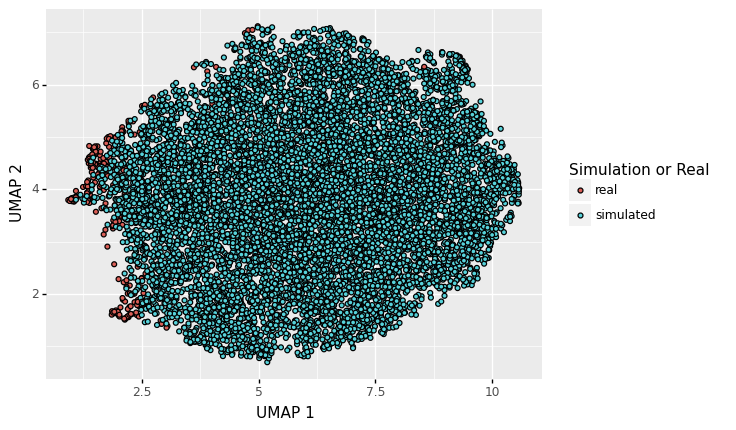

<ggplot: (8787786185277)>

In [45]:
ggplot(all_healthy_df, aes(x='UMAP 1', y='UMAP 2', fill='Simulation or Real')) + geom_point()

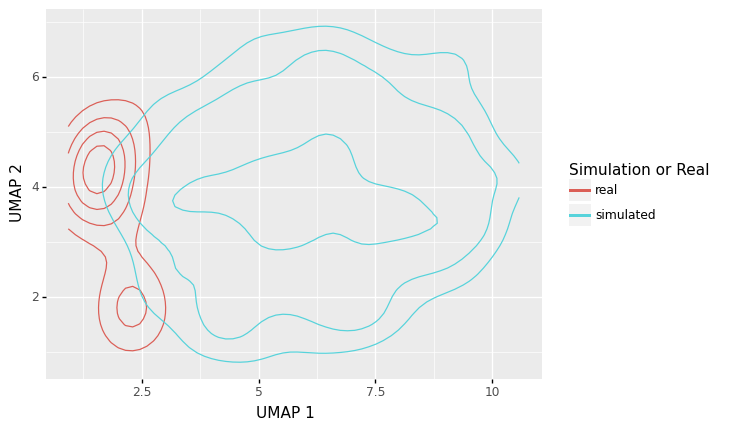

<ggplot: (8787795468049)>

In [46]:
ggplot(all_healthy_df, aes(x='UMAP 1', y='UMAP 2', color='Simulation or Real')) + geom_density_2d()

In [47]:
reducer = decomposition.PCA(n_components=2)
all_disease_umap = reducer.fit_transform(all_disease)
all_disease_umap.shape

(11098, 2)

In [48]:
reducer = decomposition.PCA(n_components=2)
all_healthy_umap = reducer.fit_transform(all_healthy)

In [49]:
all_disease_df = pd.DataFrame(all_disease_umap, columns=['PC1', 'PC2'])
all_healthy_df = pd.DataFrame(all_healthy_umap, columns=['PC1', 'PC2'])

In [50]:
all_disease_df['Simulation or Real'] = disease_labels
all_healthy_df['Simulation or Real'] = healthy_labels

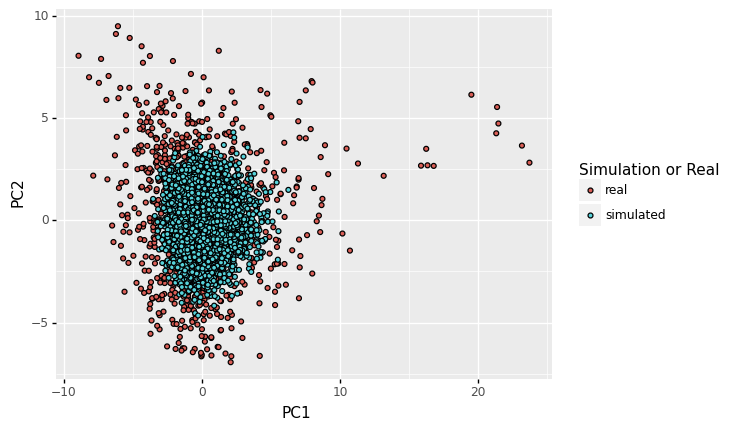

<ggplot: (8787794069973)>

In [51]:
ggplot(all_disease_df, aes(x='PC1', y='PC2', fill='Simulation or Real')) + geom_point()

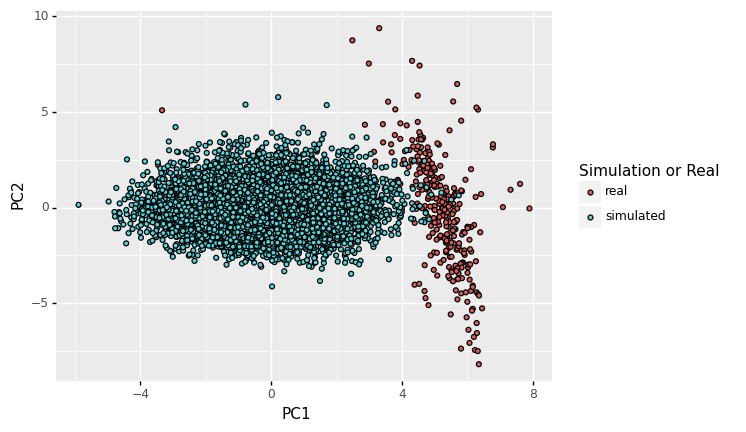

<ggplot: (8787701604013)>

In [52]:
ggplot(all_healthy_df, aes(x='PC1', y='PC2', fill='Simulation or Real')) + geom_point()

## Debugging

In [53]:
both_healthy = np.concatenate([healthy_array, healthy_array_copy], axis=0)
print(both_healthy.shape)

(628, 14634)


In [54]:
reducer = decomposition.PCA(n_components=2)
both_healthy_pca = reducer.fit_transform(both_healthy)
both_healthy_pca.shape

(628, 2)

In [55]:
both_healthy_df = pd.DataFrame(both_healthy_pca, columns=['PC1', 'PC2'])
both_healthy_df

,PC1,PC2
0,5.417450,-4.022484
1,2.140623,-0.189673
2,-1.064384,2.710246
3,2.440610,1.157082
4,5.589861,1.229141
...,...,...
623,-1.258340,-2.530420
624,-2.006451,0.112062
625,-0.662975,-0.281913
626,1.644739,0.106180


In [56]:
both_healthy_df['source'] = ['original'] * 314 + ['copy'] * 314

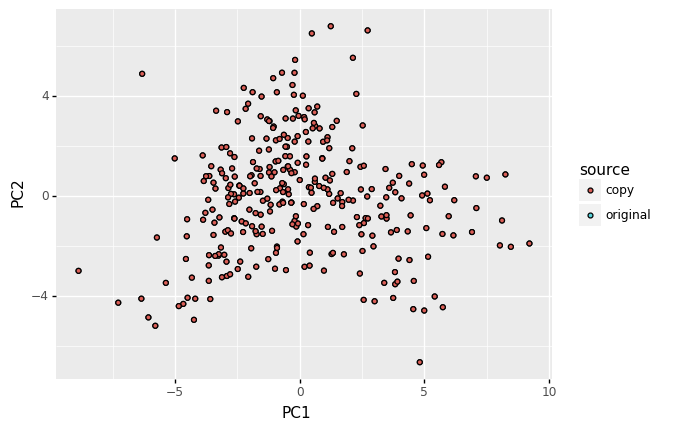

<ggplot: (8787794181485)>

In [57]:
ggplot(both_healthy_df, aes(x='PC1', y='PC2', fill='source')) + geom_point()